In [12]:
from fastai.vision.all import *

from pathlib import Path
import pandas as pd
import json

In [2]:
!hostname

AORUS-X470


In [8]:
root_dir = Path('..')

datasets_dir = root_dir/'datasets'

In [154]:
ssd_dataset = datasets_dir/'Semantic segmentation dataset'

df_classes = pd.read_csv(ssd_dataset/'classes.txt', header=None)
df_classes['name'] = df_classes[0].str.extract(r'^\d+. ([^:]+): ')[0].str.strip()
df_classes['color'] = df_classes[0].apply(lambda x: x.split(':')[-1].strip())
df_classes.index.name = 'class_id'
df_classes.reset_index(inplace=True)
df_classes.drop(columns=[0], inplace=True)


df_classes

,class_id,name,color
0,0,Building,#3C1098
1,1,Land (unpaved area),#8429F6
2,2,Road,#6EC1E4
3,3,Vegetation,#FEDD3A
4,4,Water,#E2A929
5,5,Unlabeled,#9B9B9B


In [155]:
image_paths = L(sorted([f for f in get_image_files(ssd_dataset) if 'masks' not in f.parts]))
image_paths

(#72) [Path('../datasets/Semantic segmentation dataset/Tile 1/images/image_part_001.jpg'),Path('../datasets/Semantic segmentation dataset/Tile 1/images/image_part_002.jpg'),Path('../datasets/Semantic segmentation dataset/Tile 1/images/image_part_003.jpg'),Path('../datasets/Semantic segmentation dataset/Tile 1/images/image_part_004.jpg'),Path('../datasets/Semantic segmentation dataset/Tile 1/images/image_part_005.jpg'),Path('../datasets/Semantic segmentation dataset/Tile 1/images/image_part_006.jpg'),Path('../datasets/Semantic segmentation dataset/Tile 1/images/image_part_007.jpg'),Path('../datasets/Semantic segmentation dataset/Tile 1/images/image_part_008.jpg'),Path('../datasets/Semantic segmentation dataset/Tile 1/images/image_part_009.jpg'),Path('../datasets/Semantic segmentation dataset/Tile 2/images/image_part_001.jpg'),Path('../datasets/Semantic segmentation dataset/Tile 2/images/image_part_002.jpg'),Path('../datasets/Semantic segmentation dataset/Tile 2/images/image_part_003.jpg

In [180]:
class RGB2ClassMask():

    def __init__(self, df_classes, class_id_col='class_id', color_col='color'):
        self.color2id = {
            tuple(map(int, self.hex2rgb(row[color_col]))): row[class_id_col]
            for _, row in df_classes.iterrows()
        }
        self.id2color = {v: k for k, v in self.color2id.items()}

    @classmethod
    def hex2rgb(cls, hex_color):
        hex_color = hex_color.lstrip('#')
        t = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
        return t

    @classmethod
    def rgb2hex(cls, rgb_color):
        return '#{:02x}{:02x}{:02x}'.format(*rgb_color).upper()

    def __call__(self, mask_img, verbose=False):
        print(type(mask_img))
        mask = np.array(mask_img)
        h, w, _ = mask.shape
        out = np.zeros((h, w), dtype=np.int32)
        
        for rgb, cls in self.color2id.items():
            filt = (mask == rgb).all(axis=-1)
            if verbose:
                print(f'Color {rgb} -> Class {cls}, Pixels: {filt.sum()}')
            out[filt] = cls
        
        return PILMask.create(out)
    
test = RGB2ClassMask(df_classes)
test.hex2rgb('#FF5733'), test.rgb2hex((255, 87, 51))

test_mask = image_paths[0].parent.parent/'masks'/f'{image_paths[1].stem}.png'
np.unique(test.__call__(PILImage.create(test_mask), verbose=1), return_counts=True)

<class 'fastai.vision.core.PILImage'>
Color (60, 16, 152) -> Class 0, Pixels: 0
Color (132, 41, 246) -> Class 1, Pixels: 363462
Color (110, 193, 228) -> Class 2, Pixels: 42633
Color (254, 221, 58) -> Class 3, Pixels: 0
Color (226, 169, 41) -> Class 4, Pixels: 104913
Color (155, 155, 155) -> Class 5, Pixels: 2260


(array([1, 2, 4, 5], dtype=int32), array([363462,  42633, 104913,   2260]))

In [181]:
dls = SegmentationDataLoaders.from_label_func(
    ssd_dataset,
    bs=8, 
    fnames = image_paths,
    label_func = lambda o: o.parent.parent/'masks'/f'{o.stem}.png',
    get_y=RGB2ClassMask(df_classes),
    codes = df_classes['name'].tolist(),
    item_tfms = Resize(256),
    batch_tfms=[*aug_transforms(size=(360,480)), Normalize.from_stats(*imagenet_stats)],
    device = 'cuda',
)

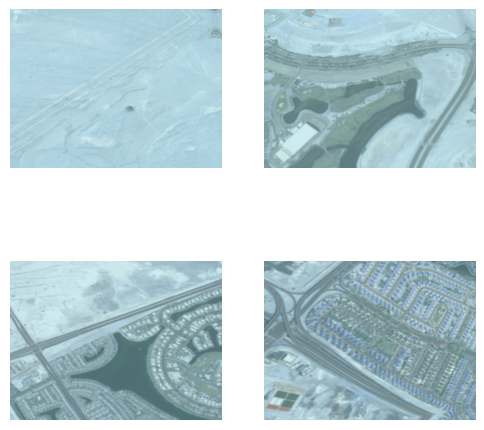

In [182]:
dls.show_batch(max_n=4)

In [ ]:

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

### tmp

In [174]:
np.unique(PILImage.create(f"{path}/labels/0001TP_006750_P.png"), return_counts=True)

(array([ 4,  5,  6,  8, 10, 12, 14, 16, 17, 19, 21, 22, 24, 26, 27, 30],
       dtype=uint8),
 array([15159,   939,     9,   471,    90,    96,   342,   513,  4602,
         2778,  5307,    84,  1203,   642,  2649,  1980]))